In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import string
import warnings
from pathlib import Path
from time import time

import arviz as az
import janitor
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns
from theano import tensor as tt

In [3]:
import src.modeling.simulation_based_calibration_helpers as sbc
from src.data_processing import achilles as achelp
from src.data_processing import common as dphelp
from src.io import cache_io
from src.loggers import logger
from src.modeling import pymc3_analysis as pmanal
from src.modeling import pymc3_sampling_api as pmapi
from src.models.speclet_six import SpecletSix
from src.plot.color_pal import FitMethodColors, ModelColors, SeabornColor
from src.project_enums import ModelFitMethod

In [4]:
notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(
    gg.theme_bw()
    + gg.theme(
        figure_size=(4, 4),
        axis_ticks_major=gg.element_blank(),
        strip_background=gg.element_blank(),
    )
)
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 300
np.random.seed(RANDOM_SEED)

HDI_PROB = 0.89

In [5]:
sp6 = SpecletSix("expt-sbc", cache_io.default_cache_dir(), debug=True)

In [8]:
# sp6.cache_manager.clear_all_caches()
sp6.cache_manager.mcmc_cache_exists()

False

In [9]:
sbc_dir = results_path = sp6.cache_manager.cache_dir / "sbc"

In [10]:
sp6.run_simulation_based_calibration(
    sbc_dir,
    fit_method=ModelFitMethod.mcmc,
    random_seed=RANDOM_SEED,
    size="small",
)

[06/12/21 13:48:37] INFO     Generating mock data of size 'small'. ]8;id=1623520118.0010726-430748;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:305

[06/12/21 13:48:38] INFO     Applying 6 data transformations.      ]8;id=1623520118.1299675-447550;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:129

                    INFO     Applying transformation: '_drop_sgrna ]8;id=1623520118.1331067-308158;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:116
                             s_that_map_to_multiple_genes'

                    WARNING  Dropping 0 sgRNA that map to multiple ]8;id=1623520118.157273-712590;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:249
                             genes.

                    INFO     Applying transformation:              ]8;id=1623520118.165409-721641;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:116
                             '_drop_missing_copynumber'

                    WARNING  Dropping 0 data points with missing   ]8;id=1623520118.172955-106278;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:259
                             copy number.

                    INFO     Applying transformation:              ]8;id=1623520118.1772242-61597;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:116
                             'centered_copynumber_by_cellline'

                    INFO     Adding 'copy_number_cellline' column.          ]8;id=1623520118.1810112-273728;file:///n/data1/hms/dbmi/park/Cook/speclet/src/models/speclet_six.py\speclet_six.py]8;;\:26

                    INFO     Applying transformation:              ]8;id=1623520118.1998248-282519;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:116
                             'centered_copynumber_by_gene'

                    INFO     Adding 'copy_number_gene' column.              ]8;id=1623520118.2031186-35014;file:///n/data1/hms/dbmi/park/Cook/speclet/src/models/speclet_six.py\speclet_six.py]8;;\:44

                    INFO     Applying transformation: 'zscale_rna_ ]8;id=1623520118.2198102-386113;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:116
                             expression_by_gene_and_lineage'

                    INFO     Adding 'rna_expr_gene_lineage' column.         ]8;id=1623520118.2227159-690251;file:///n/data1/hms/dbmi/park/Cook/speclet/src/models/speclet_six.py\speclet_six.py]8;;\:62

                    INFO     Applying transformation:              ]8;id=1623520118.343495-877469;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:116
                             'convert_is_mutated_to_numeric'

                    INFO     Converting 'is_mutated' column to 'int'.       ]8;id=1623520118.3463383-982497;file:///n/data1/hms/dbmi/park/Cook/speclet/src/models/speclet_six.py\speclet_six.py]8;;\:81

                    INFO     Calling `model_specification()` method.     ]8;id=1623520118.3520212-949716;file:///n/data1/hms/dbmi/park/Cook/speclet/src/models/speclet_model.py\speclet_model.py]8;;\:172

                    INFO     Beginning PyMC3 model specification.          ]8;id=1623520118.3562734-904974;file:///n/data1/hms/dbmi/park/Cook/speclet/src/models/speclet_six.py\speclet_six.py]8;;\:271

                    INFO     Getting Theano shared variables.              ]8;id=1623520118.380042-46252;file:///n/data1/hms/dbmi/park/Cook/speclet/src/models/speclet_six.py\speclet_six.py]8;;\:279

                    INFO     Creating PyMC3 model.                         ]8;id=1623520118.3890166-122334;file:///n/data1/hms/dbmi/park/Cook/speclet/src/models/speclet_six.py\speclet_six.py]8;;\:318

                    WARNING  Still need to implement varying effect for    ]8;id=1623520118.3925204-230422;file:///n/data1/hms/dbmi/park/Cook/speclet/src/models/speclet_six.py\speclet_six.py]8;;\:319
                             source on batch effect.

[06/12/21 13:48:48] INFO     Found 2 cell line lineages.                   ]8;id=1623520128.7445865-309829;file:///n/data1/hms/dbmi/park/Cook/speclet/src/models/speclet_six.py\speclet_six.py]8;;\:360

[06/12/21 13:48:53] INFO     Applying 6 data transformations.      ]8;id=1623520133.460233-377920;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:129

                    INFO     Applying transformation: '_drop_sgrna ]8;id=1623520133.4637055-811212;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:116
                             s_that_map_to_multiple_genes'

                    WARNING  Dropping 0 sgRNA that map to multiple ]8;id=1623520133.482172-733458;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:249
                             genes.

                    INFO     Applying transformation:              ]8;id=1623520133.4893732-866317;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:116
                             '_drop_missing_copynumber'

                    WARNING  Dropping 0 data points with missing   ]8;id=1623520133.495475-272366;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:259
                             copy number.

                    INFO     Applying transformation:              ]8;id=1623520133.499037-61690;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:116
                             'centered_copynumber_by_cellline'

                    INFO     Adding 'copy_number_cellline' column.          ]8;id=1623520133.5022612-308480;file:///n/data1/hms/dbmi/park/Cook/speclet/src/models/speclet_six.py\speclet_six.py]8;;\:26

                    INFO     Applying transformation:              ]8;id=1623520133.520132-516189;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:116
                             'centered_copynumber_by_gene'

                    INFO     Adding 'copy_number_gene' column.              ]8;id=1623520133.523179-992910;file:///n/data1/hms/dbmi/park/Cook/speclet/src/models/speclet_six.py\speclet_six.py]8;;\:44

                    INFO     Applying transformation: 'zscale_rna_ ]8;id=1623520133.5429287-510984;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:116
                             expression_by_gene_and_lineage'

                    INFO     Adding 'rna_expr_gene_lineage' column.         ]8;id=1623520133.5455966-553119;file:///n/data1/hms/dbmi/park/Cook/speclet/src/models/speclet_six.py\speclet_six.py]8;;\:62

                    INFO     Applying transformation:              ]8;id=1623520133.685931-369041;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:116
                             'convert_is_mutated_to_numeric'

                    INFO     Converting 'is_mutated' column to 'int'.       ]8;id=1623520133.6888254-351525;file:///n/data1/hms/dbmi/park/Cook/speclet/src/models/speclet_six.py\speclet_six.py]8;;\:81

                    INFO     Updating the MCMC sampling parameters.        ]8;id=1623520133.6929965-419012;file:///n/data1/hms/dbmi/park/Cook/speclet/src/models/speclet_six.py\speclet_six.py]8;;\:491

                    INFO     Beginning MCMC sampling.                    ]8;id=1623520133.697508-378390;file:///n/data1/hms/dbmi/park/Cook/speclet/src/models/speclet_model.py\speclet_model.py]8;;\:277

/n/data1/hms/dbmi/park/Cook/speclet/src/modeling/pymc3_sampling_api.py:122: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, σ_σ, a_offset, σ_a, σ_σ_a, μ_a_offset, σ_μ_a, μ_μ_a, d_offset, σ_d, σ_σ_d, μ_d_offset, σ_μ_d, μ_μ_d, h_offset, σ_h, μ_h, j_offset, σ_j, μ_j]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 1299 seconds.
The number of effective samples is smaller than 25% for some parameters.


[06/12/21 14:14:01] INFO     Finished MCMC sampling - caching results.   ]8;id=1623521641.0356708-178220;file:///n/data1/hms/dbmi/park/Cook/speclet/src/models/speclet_model.py\speclet_model.py]8;;\:290

                    INFO     Caching InferenceData to '/n/data1/hms/dbm ]8;id=1623521641.0479817-827888;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/cache_managers.py\cache_managers.py]8;;\:245
                             i/park/Cook/speclet/models/speclet-six_exp                      
                             t-sbc/mcmc/inference-data.nc'.

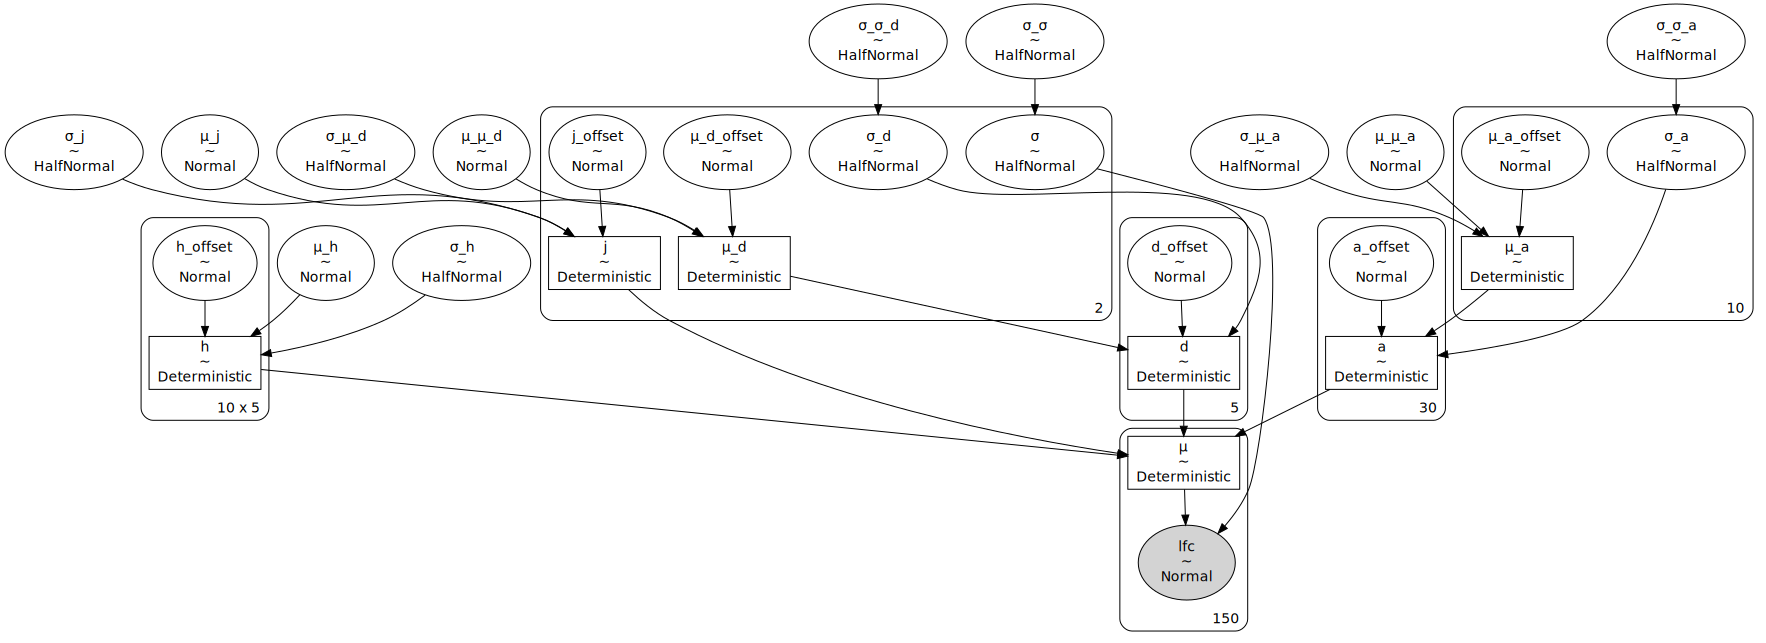

In [11]:
pm.model_to_graphviz(sp6.model)

## Visualization of mock data

In [12]:
mock_data = sp6.data_manager.get_data()
print(mock_data.shape)
mock_data.head()

(150, 15)


,depmap_id,hugo_symbol,lineage,p_dna_batch,screen,sgrna,copy_number,rna_expr,is_mutated,lfc,copy_number_cellline,copy_number_gene,rna_expr_gene_lineage,copy_number_cellline,copy_number_gene
0,cellline0,gene0,lineage0,batch0,screen0,gene0_sgrna0,0.932745,7.090937,0,2.217510,-0.090782,-0.096112,-0.742856,-0.090782,-0.096112
1,cellline0,gene0,lineage0,batch0,screen0,gene0_sgrna1,0.871185,7.246290,0,2.508963,-0.152342,-0.157672,0.755915,-0.152342,-0.157672
2,cellline0,gene0,lineage0,batch0,screen0,gene0_sgrna2,0.982572,7.241752,0,2.528404,-0.040954,-0.046285,0.712536,-0.040954,-0.046285
3,cellline1,gene0,lineage1,batch0,screen0,gene0_sgrna0,1.457007,12.607144,0,1.347310,0.433199,0.428149,-0.412557,0.433199,0.428149
4,cellline1,gene0,lineage1,batch0,screen0,gene0_sgrna1,0.955416,14.421207,0,1.415043,-0.068392,-0.073442,0.595885,-0.068392,-0.073442


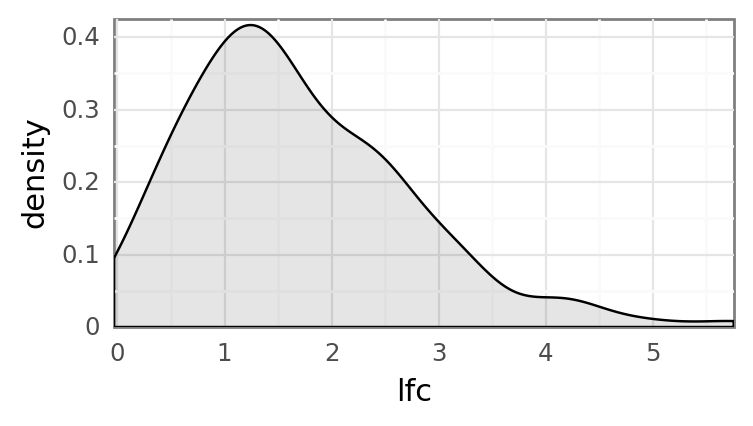

<ggplot: (8779993093768)>

In [13]:
(
    gg.ggplot(mock_data, gg.aes(x="lfc"))
    + gg.geom_density(fill="black", alpha=0.1)
    + gg.scale_x_continuous(expand=(0, 0))
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    + gg.theme(figure_size=(4, 2))
)

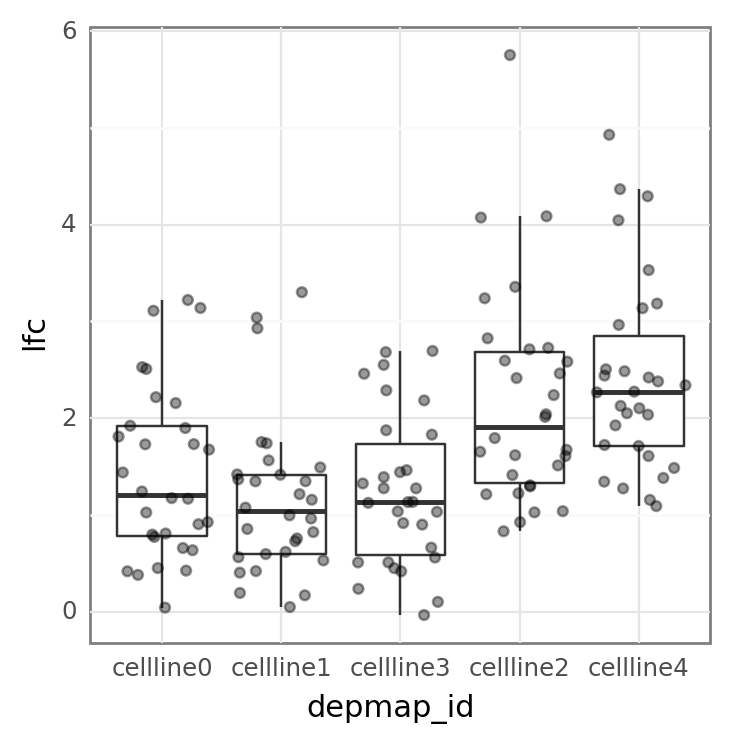

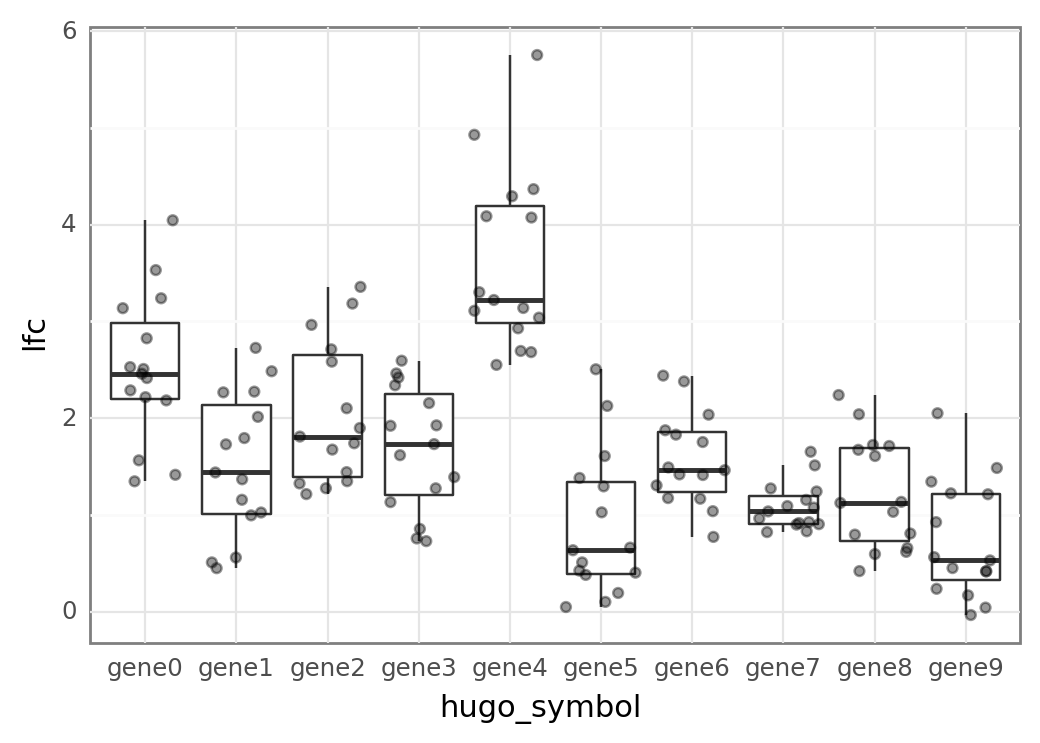

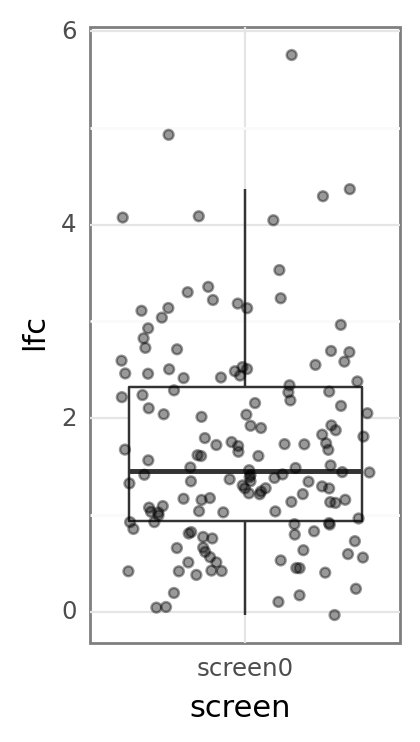

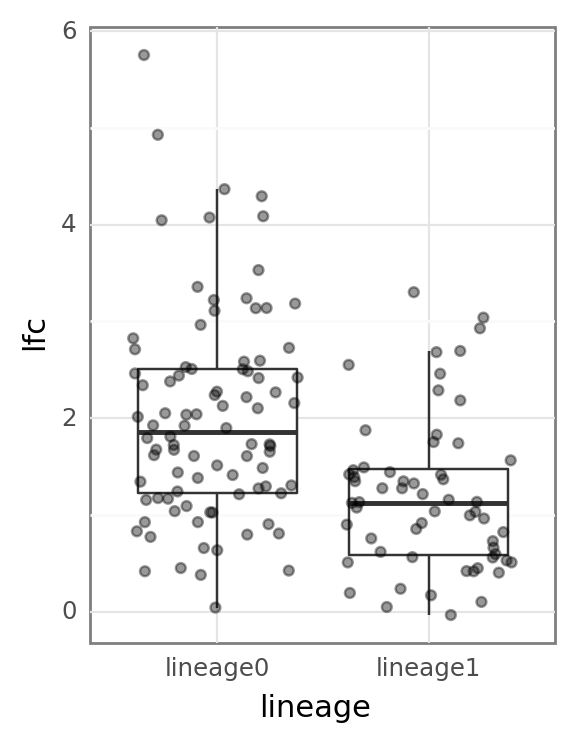

In [14]:
plot_cols = ["depmap_id", "hugo_symbol", "screen", "lineage"]
plot_sizes = [(4, 4), (6, 4), (2, 4), (3, 4)]
for col, figure_size in zip(plot_cols, plot_sizes):
    (
        gg.ggplot(mock_data, gg.aes(x=col, y="lfc"))
        + gg.geom_boxplot(outlier_alpha=0.0)
        + gg.geom_jitter(alpha=0.4)
        + gg.theme(figure_size=figure_size)
    ).draw()

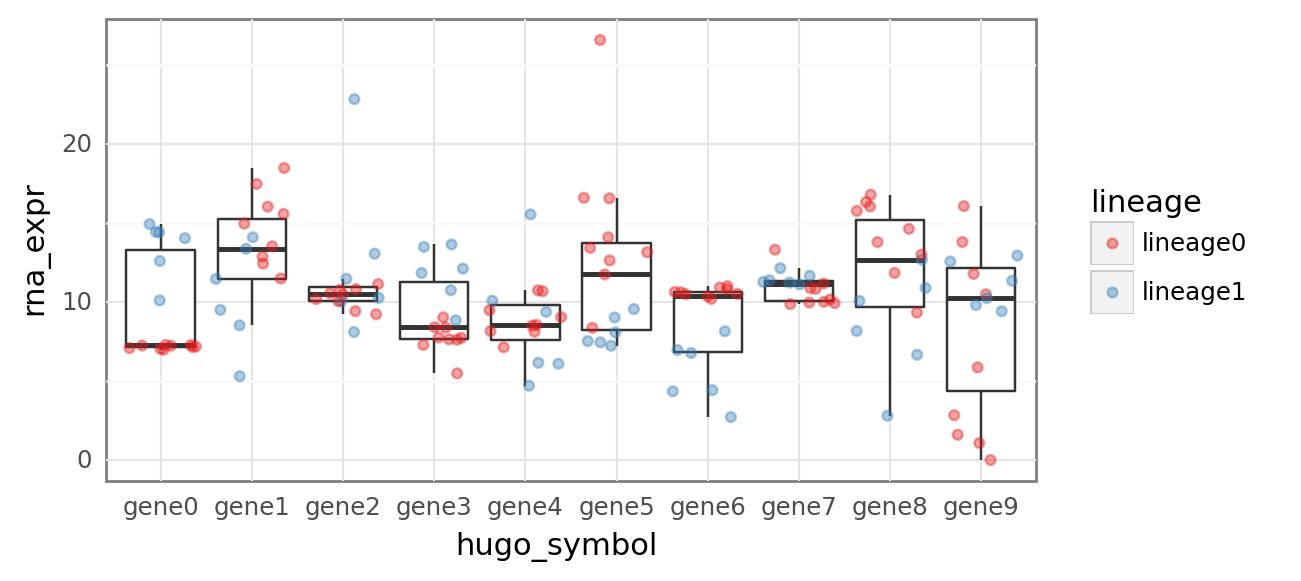

<ggplot: (8779954239741)>

In [15]:
(
    gg.ggplot(mock_data, gg.aes(x="hugo_symbol", y="rna_expr"))
    + gg.geom_boxplot(outlier_alpha=0.0)
    + gg.geom_jitter(gg.aes(color="lineage"), alpha=0.4)
    + gg.scale_color_brewer(type="qual", palette="Set1")
    + gg.theme(figure_size=(6, 3))
)

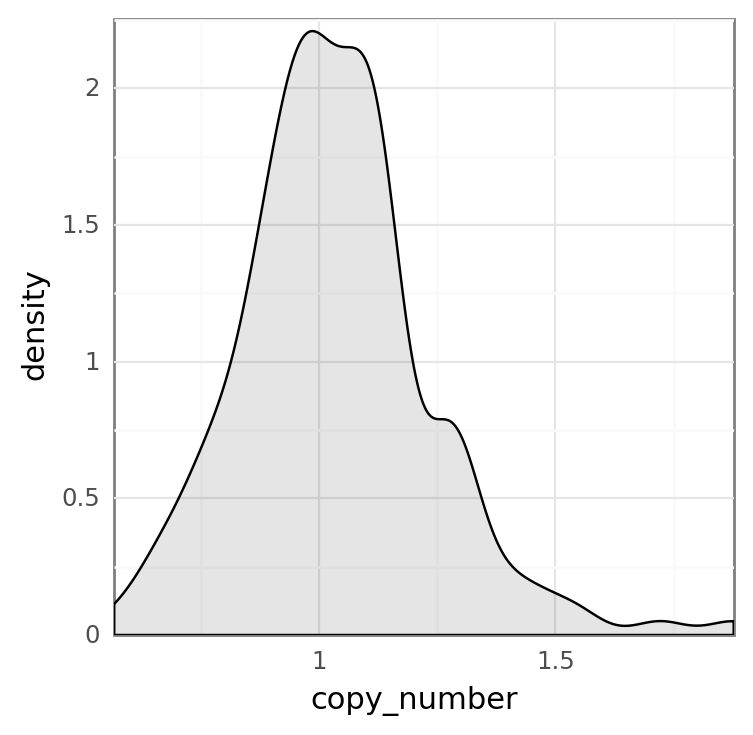

<ggplot: (8779956694414)>

In [16]:
(
    gg.ggplot(mock_data, gg.aes(x="copy_number"))
    + gg.geom_density(fill="black", alpha=0.1)
    + gg.scale_x_continuous(expand=(0, 0))
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
)

## Model parameters

In [17]:
sbc_manager = sbc.SBCFileManager(sbc_dir)

if sbc_manager.all_data_exists():
    sbc_res = sbc_manager.get_sbc_results()
else:
    FileNotFoundError("Could not locate SBC results data.")

In [18]:
sbc_res.priors["μ_a"]

array([[1.32751744, 1.43800259, 1.33298368, 1.38107235, 1.53012437,
        1.39844757, 1.42569601, 1.57365439, 1.46819278, 1.43234349]])

In [19]:
(
    sbc_res.posterior_summary.reset_index(drop=False)
    .filter_string("parameter", "^μ_a\\[")
    .filter_string("parameter", "offset", complement=True)
    .reset_index(drop=True)
    .assign(real_value=sbc_res.priors["μ_a"].flatten())
)

,parameter,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,real_value
0,μ_a[0],-0.011,0.928,-1.474,1.460,0.006,0.008,25771.0,10986.0,1.0,1.327517
1,μ_a[1],-0.006,0.928,-1.490,1.461,0.006,0.008,26223.0,11497.0,1.0,1.438003
2,μ_a[2],0.058,0.929,-1.421,1.522,0.006,0.008,25809.0,11502.0,1.0,1.332984
3,μ_a[3],-0.099,0.933,-1.539,1.427,0.006,0.008,25562.0,11388.0,1.0,1.381072
4,μ_a[4],-0.014,0.945,-1.536,1.439,0.006,0.009,26089.0,11379.0,1.0,1.530124
5,μ_a[5],-0.012,0.948,-1.526,1.467,0.006,0.008,25813.0,11782.0,1.0,1.398448
6,μ_a[6],-0.015,0.948,-1.569,1.439,0.006,0.008,25676.0,11414.0,1.0,1.425696
7,μ_a[7],-0.015,0.944,-1.509,1.474,0.006,0.008,25859.0,11854.0,1.0,1.573654
8,μ_a[8],-0.014,0.947,-1.578,1.419,0.006,0.008,25076.0,11282.0,1.0,1.468193
9,μ_a[9],-0.014,0.947,-1.563,1.451,0.006,0.009,25229.0,11456.0,1.0,1.432343


**BUG**: Distribution should be skewed negative.

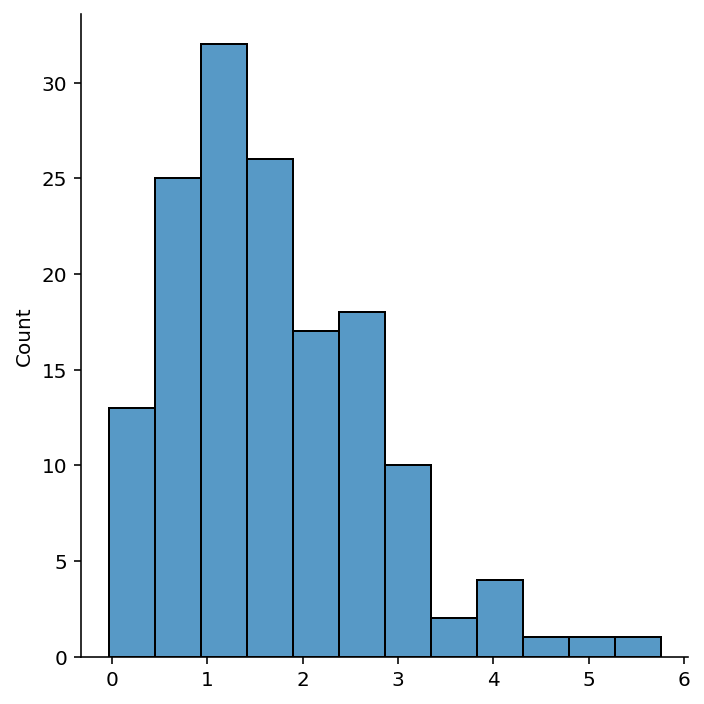

In [20]:
sns.displot(sbc_res.priors["lfc"].flatten());

/home/jc604/.conda/envs/speclet/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:>

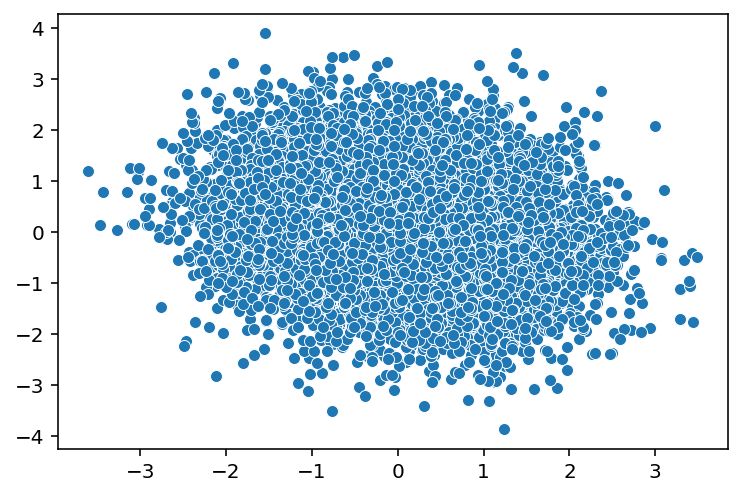

In [21]:
x = sbc_res.inference_obj.posterior["a"][:, :, 0].values.flatten()
y = sbc_res.inference_obj.posterior["d"][:, :, 0].values.flatten()
# y = sbc_res.inference_obj.posterior["d"][:, :, 0].values.flatten()
sns.scatterplot(x, y)

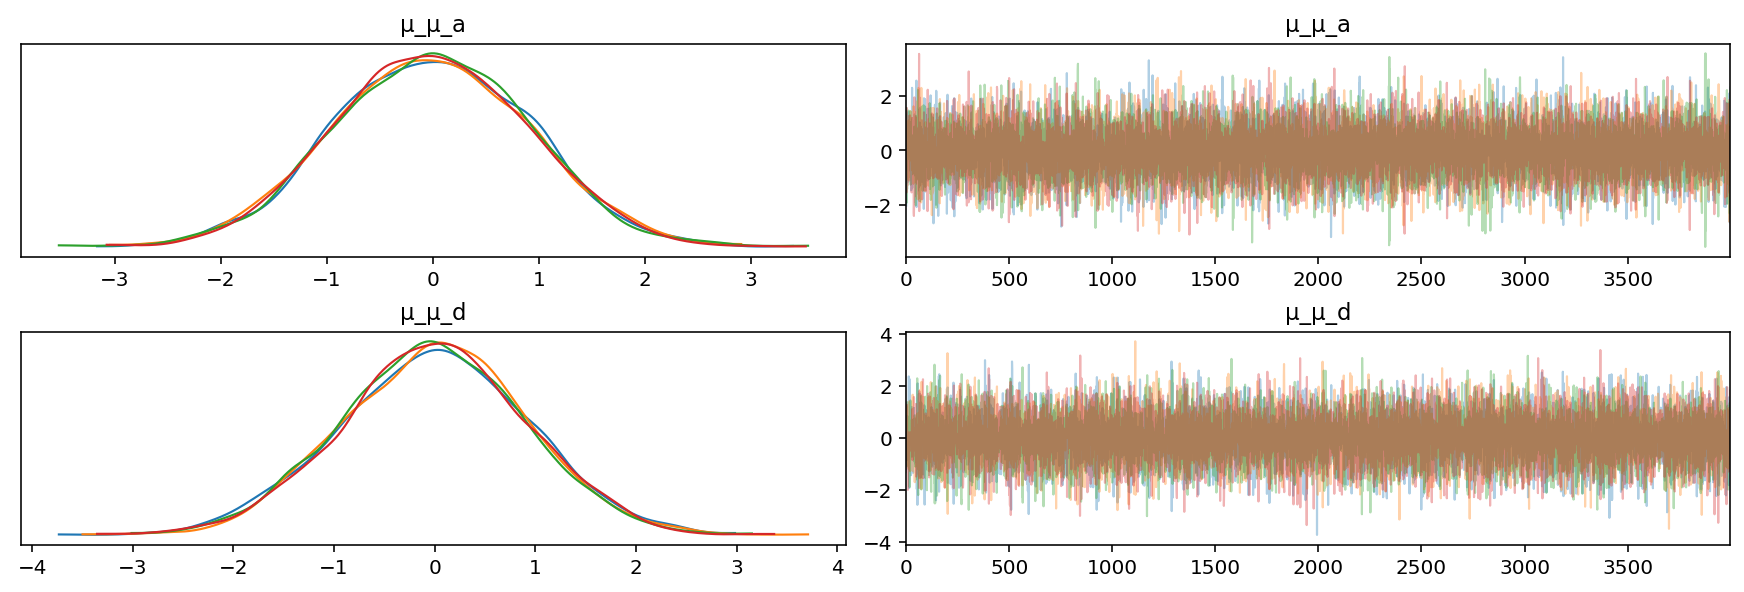

In [22]:
az.plot_trace(sbc_res.inference_obj, var_names=["μ_μ_a", "μ_μ_d"], compact=False);

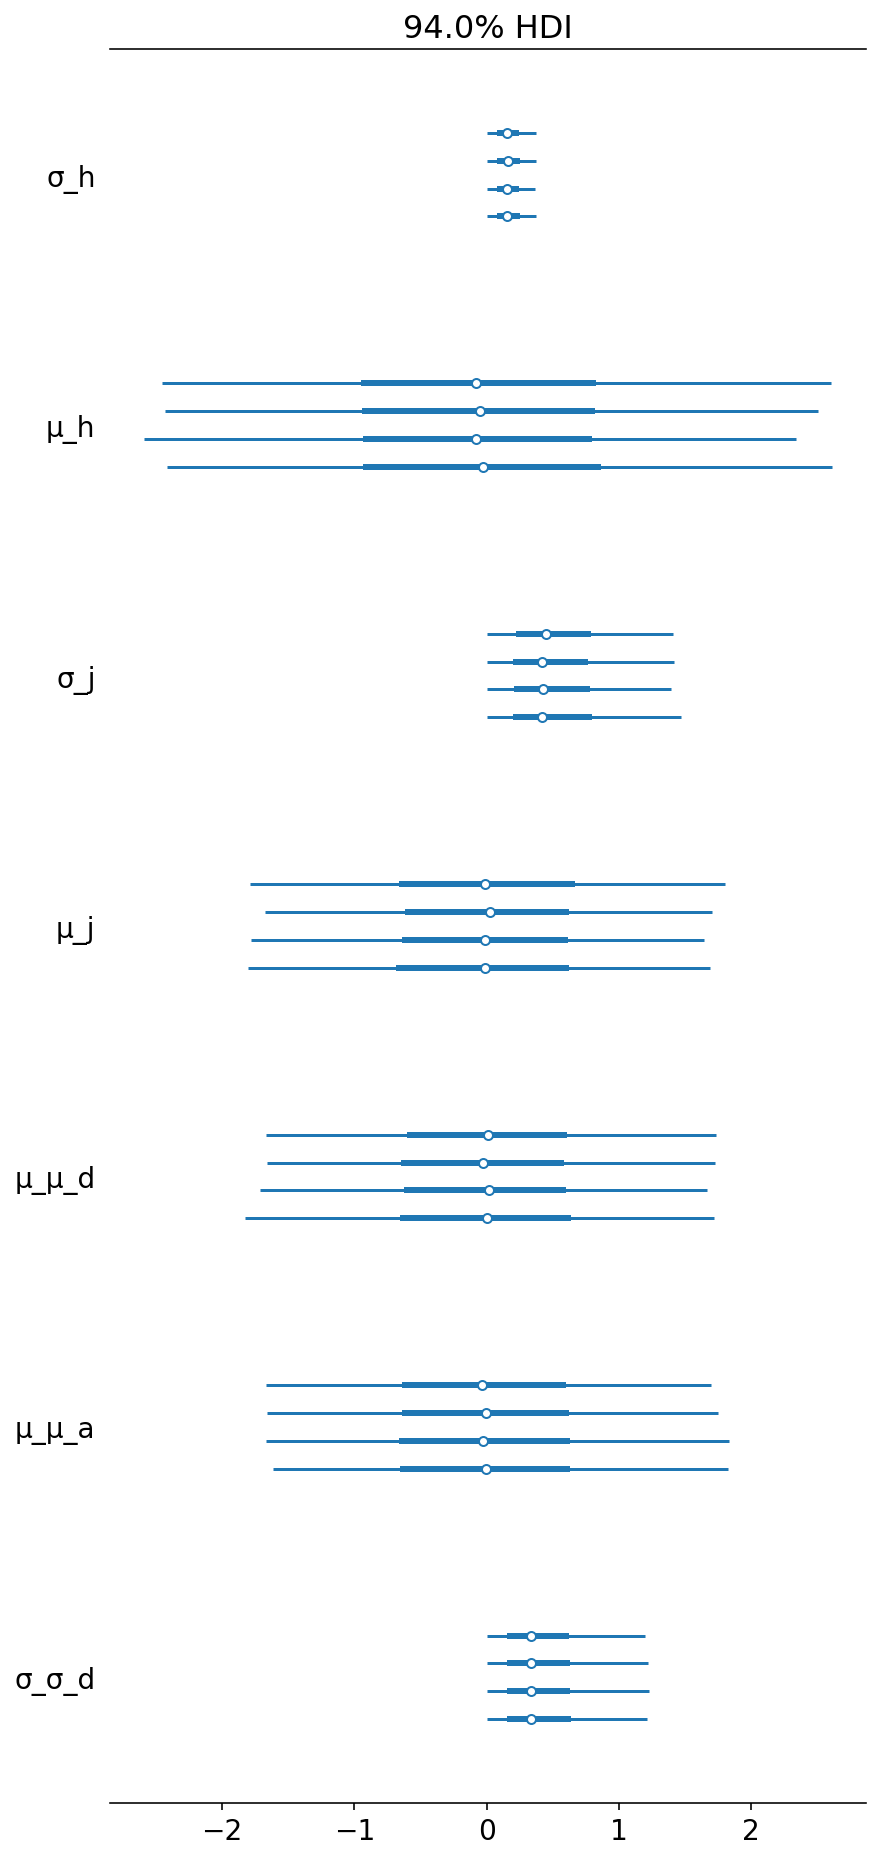

In [23]:
az.plot_forest(
    sbc_res.inference_obj,
    var_names=["σ_h", "μ_h", "σ_j", "μ_j", "μ_μ_d", "μ_μ_a", "σ_σ_d"],
);

In [24]:
az.summary(sbc_res.inference_obj, var_names=["σ_d"], hdi_prob=HDI_PROB).assign(
    real_value=sbc_res.priors["σ_d"].flatten()
)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,real_value
σ_d[0],0.202,0.238,0.0,0.452,0.002,0.002,6568.0,6166.0,1.0,0.228256
σ_d[1],0.264,0.308,0.0,0.593,0.003,0.002,5988.0,6770.0,1.0,0.048012


---

In [ ]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

In [ ]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m